# Image model pruning
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from joblib import dump
import matplotlib.pyplot as plt

from image_model_training import get_image_model, get_image_datasets
from image_model_optimization import *

## Parámetros
Se establecen los parámetros para la optimización.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
original_model_name = "MicroImgDataModel"
checkpoint_dir = f"{saved_models_dir}/tensorflow/checkpoints"
original_checkpoint_path = f"{checkpoint_dir}/{original_model_name}.hdf5"
label_index_dir = f"{saved_models_dir}/label index mappings"

model_name = f"{original_model_name}Prun"
checkpoint_path = f"{checkpoint_dir}/{model_name}.hdf5"

data_dir = f"{project_dir}/samples/microcontroller/preprocessed image/train"
log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"

validation_percentage = 20.
initial_learning_rate = 0.001
decay = (initial_learning_rate / PRUNING_EPOCHS) * 1.5

## Carga de datos
Se cargan los mismos datasets de entrenamiento y validación que se han usado en el entrenamiento.

In [3]:
train_dataset, validation_dataset = get_image_datasets(data_dir, validation_percentage)
class_names = train_dataset.class_names
nclasses = len(class_names)

class_list_text = "Classes:"
for index, name in enumerate(class_names):
    class_list_text += f"\n\t{index}: {name}"

print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(class_names, f"{label_index_dir}/{model_name}.joblib")

Found 275 files belonging to 3 classes.
Using 220 files for training.
Found 275 files belonging to 3 classes.
Using 55 files for validation.
Classes:
	0: face
	1: mask
	2: nothing


['/home/daniel/PycharmProjects/tfg-tinyml/saved models/image/label index mappings/MicroImgDataModelPrun.joblib']

## Pruning y clustering
Se aplica pruning. Primero se carga el modelo original y luego se aplica el pruning o el clustering en función de los
parámetros indicados.

In [4]:
model = get_image_model(nclasses, model_name)

model.load_weights(original_checkpoint_path)

def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                            mode='max', save_best_only=True, verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=PATIENCE)

callbacks = [LearningRateScheduler(lr_time_based_decay, verbose=1), model_checkpoint_callback, early_stopping_callback]

model = apply_pruning(model)
callbacks.append(tfmot.sparsity.keras.UpdatePruningStep())
callbacks.append(tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=PRUNING_EPOCHS,
    callbacks=callbacks
)

model.load_weights(checkpoint_path)

/home/daniel/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "MicroImgDataModelPrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 1)         0         
_________________________________________________________________
prune_low_magnitude_zero_pad (None, 97, 97, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 48, 48, 4)         74        
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 4)         17        
_________________________________________________________________
prune_low_magnitude_re_lu (P (None, 48, 48, 4)         1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 8)         578       
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 8

## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

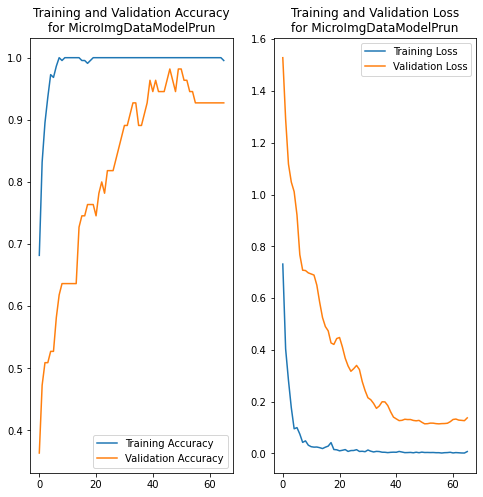

In [5]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title(f"Training and Validation Accuracy\nfor {model_name}")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title(f"Training and Validation Loss\nfor {model_name}")

plt.savefig(f"{log_dir}/{model_name}_training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [6]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModelPrun/assets


INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModelPrun/assets
